# Hidden Markov Model - Training the model

The time has come to show the training procedure.
Formally, we are interested in finding
$$
\lambda = (A, B, \pi)
$$
such that given a desired observation sequence $\mathcal{O}$, our model $\lambda$ would give the best fit.

In [1]:
%pylab inline
import numpy as np
import pandas as pd
from itertools import product
from functools import reduce

from chains import HiddenMarkovChain_Uncover
from definitions import ProbabilityMatrix, ProbabilityVector

Populating the interactive namespace from numpy and matplotlib


## Expanding the class

Here, our starting point will be the `HiddenMarkovModel_Uncover` that we have defined in the second notebook.
We will add new methods to train it.

Knowing our latent states $Q$ and possible observation states $\mathcal{O}$, we automatically know the sizes of the matrices $A$ and $B$ - $N \times N$ and $M \times M$, respectively.
However, we need to determine $\{a_{i,j}\}, \{b_j(k)\}$ and $\pi$.

For $t = 0, 1, ..., T - 2$ and $i, j \in \{0, 1, ..., N - 1\}$, we define "di-gammas":

$$
\gamma_t(i, j) = p(x_t = q_i, x_{t + 1} = q_j \ | \ \mathcal{O}, \lambda)
$$

$\gamma_t(i, j)$ is the probability of transitioning $q_t \to q_{t + 1}$.
Writing it in terms of $\alpha, \beta, A, B$, we have:

$$
\gamma_t(i, j) = \frac{\alpha_t(i)a_{i, j}b_j(\mathcal{O}_{t + 1})\beta_{t + 1}(j)}{p(\mathcal{O}|\gamma)}
$$

Now, thinking in terms of implementation, we want to avoid looping over $i, j$ and $t$ at the same time.
Fortunately, for every $t$, we can vectorize the equation (preserving that $\alpha, a$ are indexed with $t$ while $\beta, b$ are indexed with $t + 1$).

$$
\vec{\vec{\gamma_t}} = \frac{
\vec{\alpha}_t \star A^T \star \vec{b}(\mathcal{O}_{t + 1})^T \star \vec{\beta}_t
}{p(\mathcal{O}|\lambda)}
$$
where $\star$ is the element-wise multiplication, and $p(\mathcal{O}|\lambda)$ is the **score** (see the first notebook).


Having the equation for $\gamma_t(i, j)$, we can calulate
$$
\gamma_t(i) = \sum_{j = 0}^{N - 1} \gamma_t(i, j)
$$

To find $\lambda = (A, B, \pi)$, we do
1. For $i = 0, 1, ..., N - 1$:
$$
\pi_i = \gamma_{t = 0}(i)
$$
or
$$
\vec{\pi} = \vec{\gamma}_t
$$

2. For $i, j = 0, 1, ..., N - 1$:
$$
a_{i, j} = \frac{\sum_{t = 0}^{T - 2}\gamma_t(i, j)}{\sum_{t = 0}^{T - 2}\gamma_t(i)}
$$

3. For $j = 0, 1, ..., N - 1$ and $k = 0, 1, ..., M - 1$:
$$
b_j(k) = \frac{\sum_{t = 0}^{T - 1} \sum_{\mathcal{O}_t = k} \gamma_t(j)}{ \sum_{t = 0}^{T - 1}\gamma_t(j)}
$$

In [2]:
class HiddenMarkovLayer(HiddenMarkovChain_Uncover):
    def _digammas(self, observations: list) -> np.ndarray:
        L, N = len(observations), len(self.states)
        digammas = np.zeros((L - 1, N, N))

        alphas = self._alphas(observations)
        betas = self._betas(observations)
        score = self.score(observations)
        for t in range(L - 1):
            P1 = (alphas[t, :].reshape(-1, 1) * self.T.values)
            P2 = self.E[observations[t + 1]].T * betas[t + 1].reshape(1, -1)
            digammas[t, :, :] = P1 * P2 / score
        return digammas   

Having the "layer" supplemented with the `._difammas` method, we should be able to perform all the necessary calculations.
However, it makes sense to delegate the "management" of the layer to another class.
In fact, the model training can be summarized as follows:
1. We initialize $A, B$ and $\pi$.
2. We calculate $\gamma_t(i, j)$.
3. We update the model's $A, B$ and $\pi$.
4. We repeat the 2. and 3. until the score ($p(\mathcal{O}|\lambda)$) no longer increases.


In [3]:
class HiddenMarkovModel:
    def __init__(self, hml: HiddenMarkovLayer):
        self.layer = hml
        self._score_init = 0
        self.score_history = []

    @classmethod
    def initialize(cls, states: list, observables: list):
        layer = HiddenMarkovLayer.initialize(states, observables)
        return cls(layer)

    def update(self, observations: list) -> float:
        alpha = self.layer._alphas(observations)
        beta = self.layer._betas(observations)
        digamma = self.layer._digammas(observations)
        score = alpha[-1].sum()
        gamma = alpha * beta / score 

        L = len(alpha)
        obs_idx = [self.layer.observables.index(x) for x in observations]
        capture = np.zeros((L, len(self.layer.states), len(self.layer.observables)))
        for t in range(L):
            capture[t, :, obs_idx[t]] = 1.0

        pi = gamma[0]
        T = digamma.sum(axis=0) / gamma[:-1].sum(axis=0).reshape(-1, 1)
        E = (capture * gamma[:, :, np.newaxis]).sum(axis=0) / gamma.sum(axis=0).reshape(-1, 1)

        self.layer.pi = ProbabilityVector.from_numpy(pi, self.layer.states)
        self.layer.T = ProbabilityMatrix.from_numpy(T, self.layer.states, self.layer.states)
        self.layer.E = ProbabilityMatrix.from_numpy(E, self.layer.states, self.layer.observables)
            
        return score

    def train(self, observations: list, epochs: int, tol=None):
        self._score_init = 0
        self.score_history = (epochs + 1) * [0]
        early_stopping = isinstance(tol, (int, float))

        for epoch in range(1, epochs + 1):
            score = self.update(observations)
            print("Training... epoch = {} out of {}, score = {}.".format(epoch, epochs, score))
            if early_stopping and abs(self._score_init - score) / score < tol:
                print("Early stopping.")
                break
            self._score_init = score
            self.score_history[epoch] = score

## Training

In [4]:
np.random.seed(42)

observations = ['3L', '2M', '1S', '3L', '3L', '3L']

states = ['1H', '2C']
observables = ['1S', '2M', '3L']

hml = HiddenMarkovLayer.initialize(states, observables)
hmm = HiddenMarkovModel(hml)

hmm.train(observations, 25)

Training... epoch = 1 out of 25, score = 0.0013006714785001687.
Training... epoch = 2 out of 25, score = 0.005509420540117939.
Training... epoch = 3 out of 25, score = 0.005530858882821673.
Training... epoch = 4 out of 25, score = 0.005567116674468161.
Training... epoch = 5 out of 25, score = 0.005630618250468592.
Training... epoch = 6 out of 25, score = 0.005741158382934683.
Training... epoch = 7 out of 25, score = 0.0059280441106285015.
Training... epoch = 8 out of 25, score = 0.006225866084209232.
Training... epoch = 9 out of 25, score = 0.006652847604517528.
Training... epoch = 10 out of 25, score = 0.00717178787364084.
Training... epoch = 11 out of 25, score = 0.007683641981602105.
Training... epoch = 12 out of 25, score = 0.008100845554754063.
Training... epoch = 13 out of 25, score = 0.008410987791562213.
Training... epoch = 14 out of 25, score = 0.008650795046039236.
Training... epoch = 15 out of 25, score = 0.00886102147011807.
Training... epoch = 16 out of 25, score = 0.00907

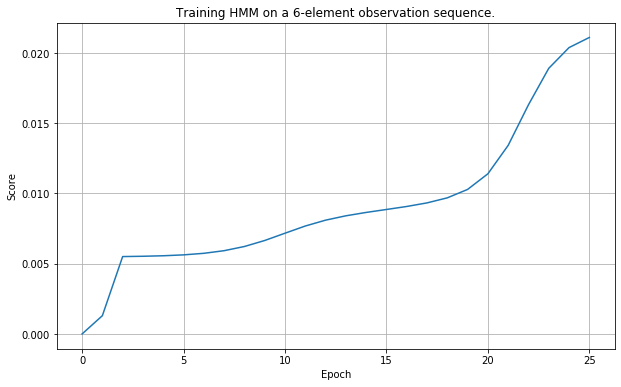

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(np.array(hmm.score_history))
ax.set_xlabel('Epoch')
ax.set_ylabel('Score')
ax.set_title('Training HMM on a 6-element observation sequence.')

plt.grid()
plt.show()

In [6]:
hmm.layer.pi.df

,1H,2C
probability,1.364191e-12,1.0


In [7]:
hmm.layer.T.df

,1H,2C
1H,0.013785,0.986215
2C,0.992353,0.007647


In [8]:
hmm.layer.E.df

,1S,2M,3L
1H,0.000001,3.357476e-01,0.664251
2C,0.330952,1.137823e-22,0.669048


In [9]:
RUNS = 100000
T = 5

chains = RUNS * [0]
for i in range(len(chains)):
    chain = hmm.layer.run(T)[0]
    chains[i] = '-'.join(chain)

## Verification
Let's look at the generated sequences.

The "demanded" sequence is:

In [10]:
pd.DataFrame(observations).T

,0,1,2,3,4,5
0,3L,2M,1S,3L,3L,3L


The table below summarizes simulated runs (based on 100000 attempts), with the frequency of occurrence and number of matching observations.

Teh bottom line is that if we have truly trained the model, we should see a strong tendency for it to generate us sequences that resemble the one we requrie. Let's see if it happens.

In [11]:
df = pd.DataFrame(pd.Series(chains).value_counts(), columns=['counts']).reset_index().rename(columns={'index': 'chain'})
df = pd.merge(df, df['chain'].str.split('-', expand=True), left_index=True, right_index=True)

s = []
for i in range(T + 1):
    s.append(df.apply(lambda x: x[i] == observations[i], axis=1))

df['matches'] = pd.concat(s, axis=1).sum(axis=1)
df['counts'] = df['counts'] / RUNS * 100
df = df.drop(columns=['chain'])
df.head(30)

,counts,0,1,2,3,4,5,matches
0,8.907,3L,3L,3L,3L,3L,3L,4
1,4.422,3L,2M,3L,3L,3L,3L,5
2,4.286,1S,3L,3L,3L,3L,3L,3
3,4.284,3L,3L,3L,3L,3L,2M,3
4,4.278,3L,3L,3L,2M,3L,3L,3
5,4.227,3L,3L,1S,3L,3L,3L,5
6,4.179,3L,3L,3L,3L,1S,3L,3
7,2.179,3L,2M,3L,2M,3L,3L,4
8,2.173,3L,2M,3L,3L,1S,3L,4
9,2.165,1S,3L,1S,3L,3L,3L,4


And here are the sequences that we don't want the model to create.

In [12]:
df.tail(10)

,counts,0,1,2,3,4,5,matches
266,0.001,1S,2M,3L,3L,2M,1S,2
267,0.001,1S,3L,3L,1S,3L,1S,1
268,0.001,1S,1S,3L,3L,2M,2M,1
269,0.001,1S,3L,2M,3L,1S,1S,1
270,0.001,3L,2M,2M,3L,3L,1S,4
271,0.001,3L,2M,2M,1S,3L,3L,4
272,0.001,3L,1S,2M,2M,1S,2M,1
273,0.001,3L,3L,2M,3L,2M,3L,3
274,0.001,3L,2M,2M,3L,2M,2M,3
275,0.001,3L,2M,1S,1S,3L,1S,4


As we can see, there is a tendency for our model to generate sequences that resemble the one we require, although the exact one (the one that matchs 6/6) places itself already at the 10th position!
On the other hand, according to the table, the top 10 sequencies are still the ones that are somewhat similar to the one we request.

To ultimately verify the quality of our model, let's plot the outcomes together with the Frequency of Occrence and compare it agains a freshly initialized model, which is supposed to give us completely random sequences - just to compare.

In [13]:
hml_rand = HiddenMarkovLayer.initialize(states, observables)
hmm_rand = HiddenMarkovModel(hml_rand)

RUNS = 100000
T = 5

chains_rand = RUNS * [0]
for i in range(len(chains_rand)):
    chain_rand = hmm_rand.layer.run(T)[0]
    chains_rand[i] = '-'.join(chain_rand)

df2 = pd.DataFrame(pd.Series(chains_rand).value_counts(), columns=['counts']).reset_index().rename(columns={'index': 'chain'})
df2 = pd.merge(df2, df2['chain'].str.split('-', expand=True), left_index=True, right_index=True)

s = []
for i in range(T + 1):
    s.append(df2.apply(lambda x: x[i] == observations[i], axis=1))

df2['matches'] = pd.concat(s, axis=1).sum(axis=1)
df2['counts'] = df2['counts'] / RUNS * 100
df2 = df2.drop(columns=['chain'])

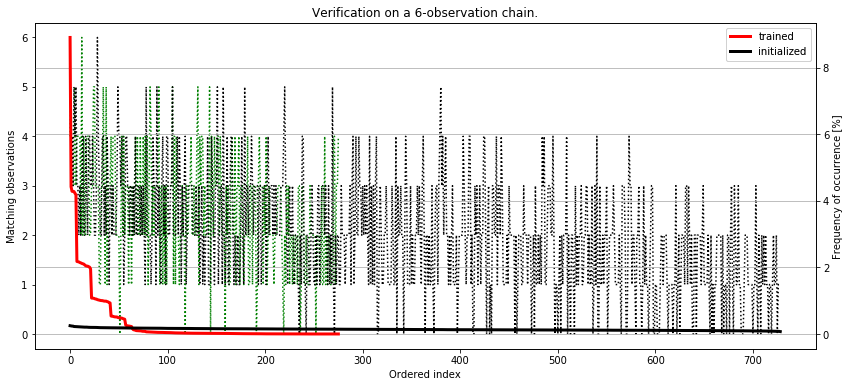

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.plot(df['matches'], 'g:')
ax.plot(df2['matches'], 'k:')

ax.set_xlabel('Ordered index')
ax.set_ylabel('Matching observations')
ax.set_title('Verification on a 6-observation chain.')

ax2 = ax.twinx()
ax2.plot(df['counts'], 'r', lw=3)
ax2.plot(df2['counts'], 'k', lw=3)
ax2.set_ylabel('Frequency of occurrence [%]')

ax.legend(['trained', 'initialized'])
ax2.legend(['trained', 'initialized'])

plt.grid()
plt.show()

## Conclusion
It seems we have successfully implemented the training procedure.
If we look at the curves, the _initialized_-only model generates observation sequences with almost equal probability. It's completely random.
However, the trained model gives sequences that are highly similar to the one we desire with much higher frequency.
Despite the genuine sequence gets created in only 2% of total runs, the other similar sequences get generated approximately as often.